## Beam problem: Eigenvalue method

### Dependencies

In [1]:
from meshes import *
from Eigenvalues import *
from NumericalSolutions import *
from DynamicSolutions import *

import matplotlib.pyplot as plt
import numpy as np
import matplotlib.font_manager

plt.style.use("standard.mplstyle")

"""
For the widgets to show up, do the following in the anaconda prompt:

conda install -c conda-forge ipywidgets
jupyter labextension install @jupyter-widgets/jupyterlab-manager
"""
import ipywidgets as widgets
from IPython.display import display
from ipywidgets import interact, interactive, fixed, interact_manual

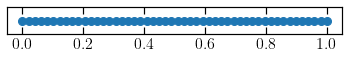

In [2]:
# Spatial resolution of mesh
N = 50

# Right limit of mesh
L = 1

# Generate 1D mesh
[nodes, elems, faces] = get_mesh_1D(N, [0,L], True);
elems = np.array(elems)   

In [3]:
E=1
I=1
mu_const = 1    
two_sided_support = False

In [4]:
### ----- Problem parameters (only used for initial solution) ------ ###

M0 = 0
ML = 0
QL = 0
a0 = 0
aL = 0
a = 0
b = 0

q = 1

In [5]:
### ----- Get initial solution as solution to static problem ----- ###
if two_sided_support:
    
    boundary_conditions = {'M0': M0, 'ML': ML, 'a0': a0, 'aL': aL}

    # Do numerical solution
    sol_num = NumericalSolutionBothEnds(ML=ML, M0=M0, a0=a0, aL=aL, E=E, I=I, N=N, L=L, q=q)
    w_num, wp_num = sol_num.solve()
    
    sol_num_dyn = DynamicSolutionBothEnds(E=E, I=I, N=N, L=L, h=0.1,
                                        initial_conditions = { "M0": M0, "ML": ML, "a0": a0, "aL": aL, "q":  q },
                                        parameters = { "M0": M0, "ML": ML, "a0": a0, "aL": aL, "q":  q })
    
    #sol_num_dyn = DynamicSolutionBothEnds(initial_conditions={"ML"=ML, "M0"=M0, "a0"=a0, "aL"=aL, "q"=q},
     #                                    parameters = {"ML"=ML, "M0"=M0, "a0"=a0, "aL"=aL, "q"=q})

else:
    
    boundary_conditions = {'QL': QL, 'ML': ML, 'a': a, 'b': b}
        
    # Do numerical solution
    sol_num = NumericalSolutionCantilever(a=a, b=b, QL=QL, ML=ML, E=E, I=I, N=N, L=L, q=q)
    w_num, wp_num = sol_num.solve()
    
    sol_num_dyn = DynamicSolutionCantilever(E=E, I=I, N=N, L=L, h=0.1,
                                        initial_conditions = { "a": a, "b": b, "QL": QL, "ML": ML, "q":  q },
                                        parameters = { "a": a, "b": b, "QL": QL, "ML": ML, "q":  q })

In [7]:
# Get matrices for eigenvalue extraction


#M_ext = get_extended_M(nodes, elems, mu_const)
#S_ext = get_extended_S(nodes, elems, E, I, two_sided_support)

M_ext = sol_num_dyn.M_ext
S_ext = sol_num.S_ext

#M = get_M_global(nodes, elems, mu_const)

M = sol_num_dyn.M

# Create time array
T = 10  # end time
Nt = 100 # no. of time steps
times = np.linspace(0, T, Nt)

# Initial values
w_init = np.zeros(np.shape(M)[0])
wp_init = np.zeros(np.shape(M)[0])

# Create solution object
sol_eigen = Eigenvalues(w0=np.ravel([w_num,wp_num],'F'), wp0=wp_init, M=M, Me=M_ext, Se=S_ext)

# Get vibration modes for w and mu
vibration_modes_w, vibration_modes_mu = sol_eigen.solve(times)

# solution is just the sum of all vibration modes
u = np.sum(vibration_modes_w, axis=0)

# Get transient solutions (w[:, k] is solution array at time step k etc.) 
w = u[:2*N, :][::2]

# get space deriative of solution w
wp = u[:2*N, :][1::2]

# get mu
mu = np.sum(vibration_modes_w, axis=0)

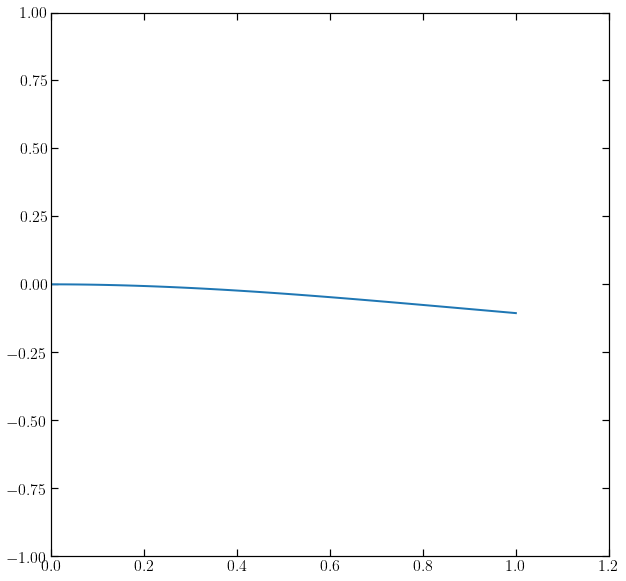

In [8]:
# get animations

%matplotlib inline

from matplotlib import animation, rc
from IPython.display import HTML

fig, ax = plt.subplots(figsize=(10,10))

ax.set_xlim(( 0, 1.2))
ax.set_ylim((-1,1))

line, = ax.plot([], [], lw=2)

def init():
    line.set_data([], [])
    return (line,)

def animate(i):
    line.set_data(nodes, w[:, i])
    return (line,)

anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=Nt, interval=10, 
                               blit=True)
HTML(anim.to_jshtml())

In [9]:
def eigenvalues_analytical(k, two_sided_support):
    # Input: no. of eigenvalues k and problem type
    # Returns: array of k eigenvalues
    
    if two_sided_support:
        kappa_j = lambda j: (j-0.5)*np.pi/L
    else:
        kappa_j = lambda j: j*np.pi/L
        
    return [np.sqrt((E*I)/mu_const)*kappa_j(j)**2 for j in range(1,k+1)]

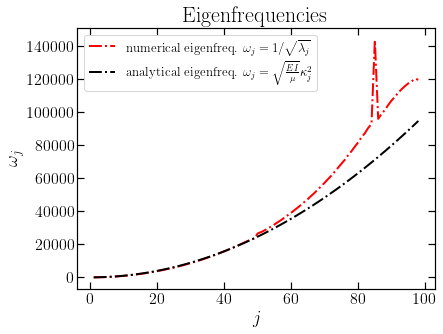

In [14]:
plt.style.use("standard.mplstyle")
plt.figure()
rg = 2*M.shape[0] - S_ext.shape[0]
eigenvalues, eigenvectors = sol_eigen.get_eigen()

plt.plot(np.arange(1,rg+1), 1/(np.sqrt(eigenvalues)),'r-.',label=r'numerical eigenfreq. $\omega_j=1/\sqrt{\lambda_j}$')
plt.plot(np.arange(1,rg+1), eigenvalues_analytical(rg, two_sided_support), 'k-.', 
         label=r'analytical eigenfreq. $\omega_j = \sqrt{\frac{EI}{\mu}}\kappa_j^2$')
plt.title("Eigenfrequencies")
plt.xlabel(r'$j$')
plt.ylabel(r'$\omega_j$')
plt.legend(prop={'size': 13})
#plt.show()
plt.savefig("./Report/eigenfrequencies.pdf")
plt.savefig("./Report/eigenfrequencies.jpeg")

Text(0, 0.5, 'Deflection ($w$)')

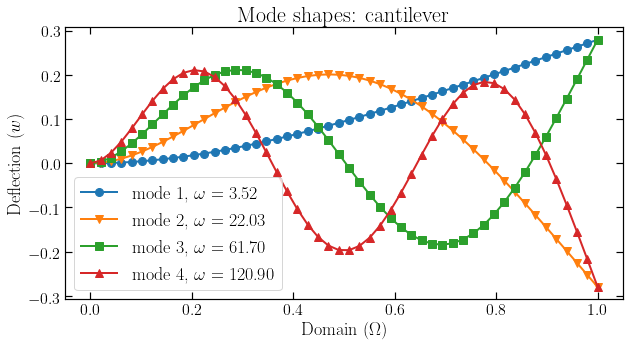

In [22]:
from matplotlib.ticker import FormatStrFormatter

markers = ["o", "v", "s", "^", "*"]

plt.figure(figsize=(10,5))
current_time = 0
for i in range(4):
    # normalize each node
    normalization = np.linalg.norm(vibration_modes_w[i][:, current_time][::2])
    plt.plot(nodes, vibration_modes_w[i][:, current_time][::2]/normalization, "-"+markers[i],label=r'mode %i' % (i+1) +
             r', $\omega=$ %.2f' % (1/(np.sqrt(eigenvalues[i]))))
    
plt.legend(prop={'size': 18})
plt.title(r'Mode shapes: cantilever')
plt.xlabel(r'Domain ($\Omega$)')
plt.ylabel(r'Deflection ($w$)')
#plt.savefig("./Report/vibration_modes_cantilever.pdf")

## Animation vibration modes

In [1]:
matplotlib.use('Agg')

fig = plt.figure(figsize=(10,5))

ax = plt.axes(xlim=(0, 1.2), ylim=(-0.3, 0.3))
ax.set_title('Time dependency of vibration modes')
ax.set_xlabel(r'Domain ($\Omega$)')
ax.set_ylabel(r'Deflection ($w$)')

k = 5
lines = [plt.plot([], [],'-o', label='mode %i' % i)[0] for i in range(k)] #lines to animate
ax.legend(loc='lower right', prop={'size': 18})

def init():
    #init lines
    for line in lines:
        line.set_data([], [])

    return lines

def animate(i):
    #animate lines
    for j,line in enumerate(lines):
        line.set_data(nodes, vibration_modes_w[j][:, i][::2]/(np.linalg.norm(vibration_modes_w[j][:, 0][::2])))

    return lines #return everything that must be updated

anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=Nt, interval=20, blit=True)

dpi = 200
writer = animation.writers['ffmpeg'](fps=20)
anim.save('./Report/animation_modes.mp4',writer=writer,dpi=dpi)

NameError: name 'matplotlib' is not defined